In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px

from sklearn.decomposition import PCA

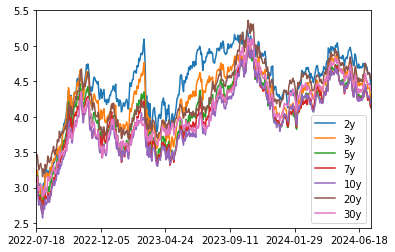

In [3]:
benchmark_curve = pd.read_csv('./data/benchmark_curve.csv', index_col=0)
benchmark_curve.plot()

In [4]:
pca = PCA(n_components=3)
pca.fit_transform(benchmark_curve.diff().dropna())

# % explained by each PC
print(pca.explained_variance_ratio_)

[0.89471702 0.0912205  0.00853336]


Text(0.5,1,'First PC does indeed track the outright yield moves well')

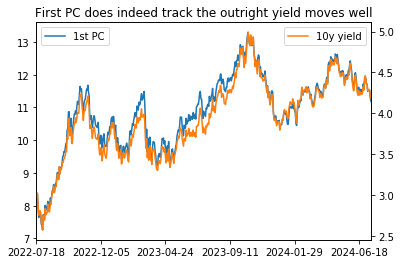

In [18]:
pcs = benchmark_curve @ pca.components_.T 
ax = (-1 * pcs[0]).plot(label='1st PC')
ax2 = benchmark_curve['10y'].plot(secondary_y=True, ax=ax, label='10y yield')
ax.legend(loc='upper left')
ax2.legend(loc=1)
plt.title('First PC does indeed track the outright yield moves well')

In [59]:
df = benchmark_curve.loc['2024-01-12':]

In [60]:
import statsmodels.api as sm

In [61]:
left = '2y'
belly = '3y'
right = '5y'

X = pd.concat([df[belly], df[right] - df[left]], axis=1, keys=['duration', 'curve'])
y = 2 * df[belly] - df[left] - df[right]

In [62]:
X = sm.add_constant(X) 
ols = sm.OLS(y, X).fit() 

/Users/Mike/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2542: FutureWarning:

Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.



In [63]:
ols.params

const      -0.623331
duration    0.116839
curve      -0.113357
dtype: float64

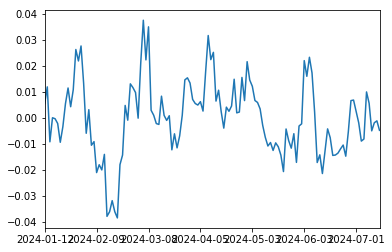

In [64]:
ols.resid.plot()

In [65]:
B1 = ols.params['duration']
B2 = ols.params['curve']
w1, w2 = ((-1 + B2) * 2 / (2 - B1),  (-1 - B2) * 2 / (2 - B1))

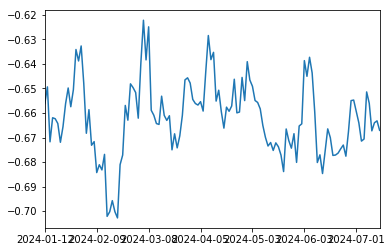

In [66]:
(2 * df[belly] + w1 * df[left] + w2 * df[right]).plot()

In [67]:
ols.resid

2024-01-12    0.005521
2024-01-15    0.011914
2024-01-16   -0.009175
2024-01-17    0.000057
2024-01-18   -0.000314
                ...   
2024-07-08    0.005615
2024-07-09   -0.004969
2024-07-10   -0.001862
2024-07-11   -0.001132
2024-07-12   -0.004776
Length: 130, dtype: float64

In [68]:
(2 * df[belly] + w1 * df[left] + w2 * df[right]) - ols.params['const']

2024-01-12   -0.032810
2024-01-15   -0.026021
2024-01-16   -0.048418
2024-01-17   -0.038614
2024-01-18   -0.039008
                ...   
2024-07-08   -0.032711
2024-07-09   -0.043952
2024-07-10   -0.040651
2024-07-11   -0.039876
2024-07-12   -0.043746
Length: 130, dtype: float64

In [69]:
w1, w2

(-1.1824341446901878, -0.9416537076342375)

In [74]:
def get_duration_neutral_butterfly(my_df, left, belly, right, method='duration'):
    '''
    input: "regression" or "pca", and tenors of the fly
    output: (w1, w2), weights for w1_2_w2 fly that neutralizes duration and curve

    for regression:
        -1 * left + 2 * belly - 1 * right = B1 * belly + B2 * (right - left) + Err
        -1 * left + 2 * belly - 1 * right = B1 * belly + B2 * right - B2 * left + Err
        (-1 + B2) * left + (2 - B1) * belly + (-1 - B2) * right = Err
        (-1 + B2) * 2 / (2 - B1) * left + 2 * belly + (-1 - B2) * 2 / (2 - B1) * right = Err
        so return [(-1 + B2) * 2 / (2 - B1),  (-1 - B2) * 2 / (2 - B1)]
    '''

    fly =  2 * df[belly] - df[left] - df[right]
    left_ts = my_df[left]
    belly_ts = my_df[belly]
    right_ts = my_df[right]

    if method == 'duration':
        X = pd.concat([belly_ts, right_ts - left_ts], axis=1, keys=['duration', 'curve'])
        y = fly
        ## fit a OLS model with intercept on TV and Radio 
        X = sm.add_constant(X) 
        ols = sm.OLS(y, X).fit() 

        B1 = ols.params['duration']
        B2 = ols.params['curve']
        w1, w2 = ((-1 + B2) * 2 / (2 - B1),  (-1 - B2) * 2 / (2 - B1))
        w1 = round(w1, 2)
        w2 = round(w2, 2)
        return w1, w2

In [75]:
def get_wtd_butterfly(my_df, left, belly, right, left_weight=-1, right_weight=-1, scale=True):
    '''
    pass in butterfly tenors, ex: 2y
    without speciying weights, assume 1:2:1 weighted butterfly

    return time series of the butterfly
    '''

    # returns a 1:2:1 fly, in bps, by default
    return 100 * (2 * my_df[belly] + (my_df[left] * left_weight + my_df[right] * right_weight))


In [76]:
get_duration_neutral_butterfly(df, '2y', '3y', '5y')

/Users/Mike/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2542: FutureWarning:

Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.



(-1.18, -0.94)

In [97]:
my_pca = PCA(n_components=1)
my_pca.fit_transform(benchmark_curve[['2y', '3y', '5y']].diff().dropna())

array([[-9.43855163e-02],
       [ 1.05058082e-02],
       [ 2.86362221e-01],
       [ 2.33008950e-01],
       [-7.39925908e-02],
       [-5.22307429e-02],
       [ 1.00144356e-01],
       [ 2.52017234e-01],
       [ 1.48610807e-03],
       [ 4.06326171e-02],
       [-3.50695659e-01],
       [ 9.27004535e-03],
       [ 5.48670950e-02],
       [-3.15827734e-01],
       [ 6.48427195e-02],
       [-1.01612303e-01],
       [ 8.49760133e-02],
       [-5.15104375e-02],
       [ 8.38322376e-04],
       [ 1.10449883e-01],
       [-1.22134528e-01],
       [-1.12039809e-01],
       [ 8.72831150e-02],
       [-6.90950805e-02],
       [-1.26210290e-01],
       [ 7.20323843e-03],
       [-9.41717625e-02],
       [ 6.93435401e-02],
       [-6.47502232e-02],
       [-5.92061334e-02],
       [-2.86086565e-02],
       [-1.03066077e-01],
       [-4.55384335e-02],
       [ 1.92773516e-01],
       [ 4.97935126e-03],
       [-2.35392156e-01],
       [ 1.41691415e-01],
       [-1.25868505e-01],
       [-6.0

In [119]:
benchmark_curve[['2y', '3y', '5y']] @ my_pca.components_.T

,0,1,2
2022-07-18,5.463377,0.173705,0.101519
2022-07-19,5.561101,0.186465,0.100425
2022-07-20,5.554855,0.169772,0.109073
2022-07-21,5.271357,0.188627,0.108577
2022-07-22,5.041594,0.196651,0.114332
...,...,...,...
2024-07-08,7.663418,0.412440,0.234640
2024-07-09,7.660918,0.406777,0.238691
2024-07-10,7.652288,0.406972,0.237456
2024-07-11,7.475195,0.393226,0.237443


In [121]:
(benchmark_curve[['2y', '3y', '5y']] @ my_pca.components_.T)[0].corr(benchmark_curve['3y'])

0.9979820285906927

In [123]:
np.sign(1)

1

In [100]:
a = np.array([-1, 2, -1]) / my_pca.components_[0, :] 
a /= (a[1] * 0.5)
a
w1 = a[0]
w2 = a[2]

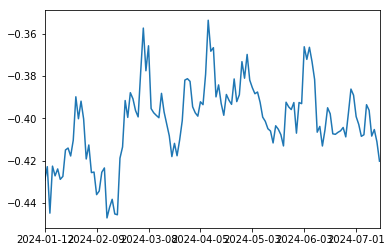

In [102]:
(2 * df[belly] + w1 * df[left] + w2 * df[right]).plot()

In [109]:
df.head()

,2y,3y,5y,7y,10y,20y,30y
2024-01-12,4.127499,3.924201,3.848599,3.866949,3.938445,4.312095,4.153103
2024-01-15,4.126595,3.927991,3.850574,3.860473,3.938288,4.312839,4.151202
2024-01-16,4.202000,4.010000,3.953854,3.971154,4.056827,4.435126,4.273565
2024-01-17,4.342302,4.139759,4.042863,4.043498,4.102563,4.467508,4.291801
2024-01-18,4.331558,4.143573,4.064873,4.071734,4.140339,4.514974,4.343419


In [114]:
my_pca = PCA(n_components=3)
my_pca.fit_transform(df[[left, belly, right]].diff().dropna()) # innately assumes change in yields have mean 0 and follow a normal distribution
pc0 = my_pca.components_[0, :]
pc1 = my_pca.components_[1, :]
A = np.array([[pc0[0], pc0[2]], [pc1[0], pc1[2]]])
b = -2 * np.array([pc0[1], pc1[1]]).T
w1, w2 = (np.linalg.solve(A, b))

In [115]:
w1

-1.3160088562195296

In [116]:
w2

-0.7813885291559045

In [118]:
np.array([w1, 2, w2]) @ pc1

0.0

In [105]:
a, b = np.array([-1.,  1.])

In [107]:
a, b

(-1.0, 1.0)

In [169]:
def find_most_attractive_flies(my_df, method='duration', rich=True, num=3):
    benchmark_points = my_df.columns
    if len(benchmark_points) < 3: return # need to have at least 4 points
    
    my_results = []
    all_flies = combinations(benchmark_points, 3)
    for left, belly, right in all_flies:
        w1, w2 = get_duration_neutral_butterfly(my_df, left, belly, right, method=method)
        wtd_fly = get_wtd_butterfly(my_df, left, belly, right, left_weight=w1, right_weight=w2)
        print(wtd_fly.iloc[-5:])
        my_fly_name = '%s_%s_%s fly' % (left, belly, right)
        # calculates various stats on the fly for display

        fly_avg = wtd_fly.mean()
        resid = wtd_fly[-1] - fly_avg
        print(wtd_fly[-1], fly_avg)
        rlzd_vol = wtd_fly.diff().dropna().std()
        vol_adj_resid = resid / rlzd_vol
        my_range = wtd_fly.max() - wtd_fly.min()

        relevant_stats = {
            'fly name': my_fly_name,
            'left weight': w1,
            'belly weight': 2,
            'right weight': w2,
            'residual': resid,
            'rlzd vol': rlzd_vol,
            'vol_adj_residual': vol_adj_resid,
            'range': my_range
        }
        my_results.append(relevant_stats)
        break
    my_results = pd.DataFrame(my_results).round(1)
    # richest fly want the most negative residuals
    my_results = my_results.sort_values('vol_adj_residual', ascending=rich)
    return my_results

In [170]:
a = find_most_attractive_flies(df, rich=False)
a

2024-07-08    1827.784681
2024-07-09    1826.723404
2024-07-10    1824.753174
2024-07-11    1782.006635
2024-07-12    1759.887622
dtype: float64
1759.88762249551 1851.8635192588658


/Users/Mike/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2542: FutureWarning:

Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.



,fly name,left weight,belly weight,right weight,residual,rlzd vol,vol_adj_residual,range
0,2y_3y_5y fly,-1.2,2,-0.9,-92.0,25.2,-3.7,382.0


In [152]:
a

,fly name,left weight,belly weight,right weight,residual,rlzd vol,vol_adj_residual,range
33,7y_20y_30y fly,0.3,2,-2.2,-32.2,20.1,-1.6,281.7
24,3y_20y_30y fly,0.1,2,-2.0,-32.8,20.3,-1.6,283.2
14,2y_20y_30y fly,0.1,2,-2.0,-32.8,20.2,-1.6,282.2
34,10y_20y_30y fly,-0.2,2,-1.6,-34.8,20.1,-1.7,282.6
30,5y_20y_30y fly,0.1,2,-2.0,-33.4,20.2,-1.7,282.5
31,7y_10y_20y fly,-0.8,2,-1.4,-52.0,23.7,-2.2,330.7
32,7y_10y_30y fly,-0.6,2,-1.6,-53.2,22.8,-2.3,329.0
12,2y_10y_20y fly,-0.6,2,-1.6,-53.2,23.0,-2.3,325.2
28,5y_10y_20y fly,-1.0,2,-1.0,-54.3,22.9,-2.4,325.0
22,3y_10y_20y fly,-0.7,2,-1.4,-53.8,22.8,-2.4,323.9


In [139]:
from itertools import combinations

In [141]:
list(combinations(df.columns, 3))

[('2y', '3y', '5y'),
 ('2y', '3y', '7y'),
 ('2y', '3y', '10y'),
 ('2y', '3y', '20y'),
 ('2y', '3y', '30y'),
 ('2y', '5y', '7y'),
 ('2y', '5y', '10y'),
 ('2y', '5y', '20y'),
 ('2y', '5y', '30y'),
 ('2y', '7y', '10y'),
 ('2y', '7y', '20y'),
 ('2y', '7y', '30y'),
 ('2y', '10y', '20y'),
 ('2y', '10y', '30y'),
 ('2y', '20y', '30y'),
 ('3y', '5y', '7y'),
 ('3y', '5y', '10y'),
 ('3y', '5y', '20y'),
 ('3y', '5y', '30y'),
 ('3y', '7y', '10y'),
 ('3y', '7y', '20y'),
 ('3y', '7y', '30y'),
 ('3y', '10y', '20y'),
 ('3y', '10y', '30y'),
 ('3y', '20y', '30y'),
 ('5y', '7y', '10y'),
 ('5y', '7y', '20y'),
 ('5y', '7y', '30y'),
 ('5y', '10y', '20y'),
 ('5y', '10y', '30y'),
 ('5y', '20y', '30y'),
 ('7y', '10y', '20y'),
 ('7y', '10y', '30y'),
 ('7y', '20y', '30y'),
 ('10y', '20y', '30y')]